# [Module 1.2] 데이터 탐색

이 노트북에서는 아래와 같은 데이터 탐색을 합니다.
- Product_id 에 따른 판매 갯수 분포
- 아래 항목별 판매 개수 및 classes의 평균 분포
    - 제품 카테고리
    - customer zip code
    - customer city
    - customer state
    - seller zip code
    - seller city
    - seller state
- 일자 별 판매 갯수
- 숫자(Numeric)컬럼 값의 분포 및 레이블 영향 확인
    - 'price','freight_value',
    - 'product_weight_g','product_length_cm','product_height_cm','product_width_cm'
- Correlation 매트릭스 확인

### 결론적으로 데이터 탐색을 통해서 보면 아래의 컬럼들이 배달 시간(Classes)에 영향을 주었습니다.
이 결과를 기반으로 Feature Engineering을 다음 노트북에서 진행 하겠습니다.
- customer zip code
- customer city
- seller zip code
- seller city
- 판매 일자    
- freight_value

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format='retina'



In [2]:
%store -r full_data_file_name

In [3]:
full_data_file_name

'preproc_data/join_data/full_data.csv'

In [4]:
df = pd.read_csv(full_data_file_name)
print("df shape: ", df.shape)
df.head(2)

df shape:  (67176, 17)


,classes,order_approved_at,customer_id,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,2,2017-10-02 11:07:15,9ef432eb6251297304e76186b10a928d,3149,sao paulo,SP,29.99,8.72,87285b34884572647811a353c7ac498a,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,0,2017-08-15 20:05:16,a20e8105f23924cd00833fd87daa0831,3366,sao paulo,SP,29.99,7.78,87285b34884572647811a353c7ac498a,500.0,19.0,8.0,13.0,housewares,9350,maua,SP


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67176 entries, 0 to 67175
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   classes                        67176 non-null  int64  
 1   order_approved_at              67176 non-null  object 
 2   customer_id                    67176 non-null  object 
 3   customer_zip_code_prefix       67176 non-null  int64  
 4   customer_city                  67176 non-null  object 
 5   customer_state                 67176 non-null  object 
 6   price                          67176 non-null  float64
 7   freight_value                  67176 non-null  float64
 8   product_id                     67176 non-null  object 
 9   product_weight_g               67176 non-null  float64
 10  product_length_cm              67176 non-null  float64
 11  product_height_cm              67176 non-null  float64
 12  product_width_cm               67176 non-null 

### Product_ID의 팔린 개수에 따른 분포

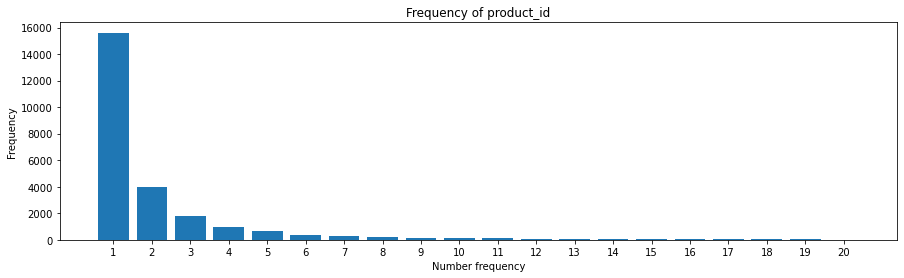

In [6]:
# import IPython.display as dp
from IPython.display import display as dp
def plot_sparse(df, col, num=20):
    '''
    컬럼의 값에 따른 개수를 구하여 가시화
    '''
    stats = df[[col, 'classes']].groupby(col).agg(['count','mean','sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean','sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    # dp(stats_sort)
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:num], stats_sort['count'].values[0:num])
    plt.title('Frequency of ' + str(col))
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')
    # dp(stats_sort)

col= 'product_id'    
plot_sparse(df, col, num=20)    

## 카테고리 별 판매 개수 및 Classes 값의 평균 분포

In [7]:
def plot_topN(df, col,num):
    '''
    컬럼의 갯수와 평균값을 보여줌
    '''
    stats = df[[col, 'classes']].groupby(col).agg(['count', 'mean'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean']
    stats = stats.sort_values('count', ascending=False)
    # dp(stats)
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.bar(stats[col].astype(str).values[0:num], stats['count'].values[0:num])
    ax1.set_xticklabels(stats[col].astype(str).values[0:num], rotation='vertical')
    ax2.plot(stats['mean'].values[0:num], color='red')
    ax2.set_ylim(0,4)
    ax2.set_ylabel('Mean Target')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(col)
    ax1.set_title('TopN ' + col + 's based on frequency')

왼쪽 축은 카테고리별 판매된 갯수를 나타내며, 오른쪽 축은 레이블 (0,1,2,3,4)에 대한 카테고리별 평균 값을 의미 합니다. 예를 들어서 bed_bath_table은 약 2.0 에 가까운 수치를 보이는데, 2.0 의 레이블의 의미는 ```2: 5 - 8일 (6일 - 8일 23:59:59)``` 를 의미합니다. 즉 약 5-8일이 걸린다는 것을 의미 합니다.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


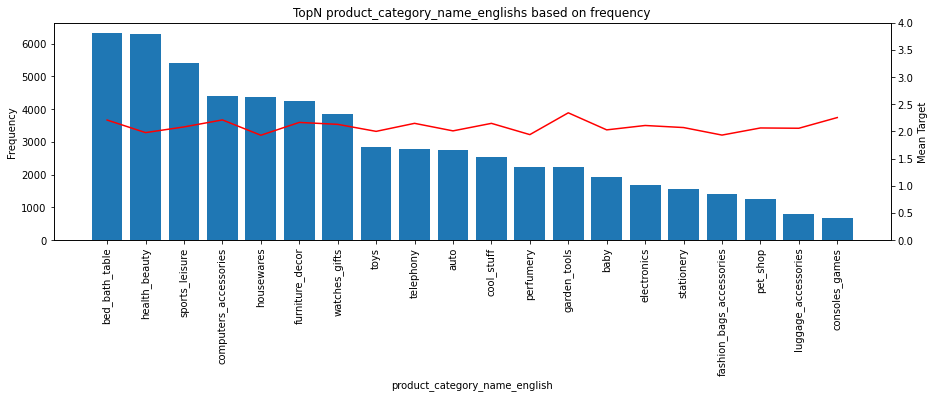

In [8]:
col= 'product_category_name_english'    
plot_topN(df, col, num=20)    

## Customer Zip 별 판매 개수 및 Classes 값의 평균 분포
예를 들어서 특정 zip code는 오른쪽 Target의 평균이 약 1.0 에 가까운 수치를 보이는데, 1.0 의 레이블의 의미는 ```1: 2 - 5일 (3일 - 5일 23:59:59)``` 를 의미합니다. 즉 약 3-5일이 걸린다는 것을 의미 합니다.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


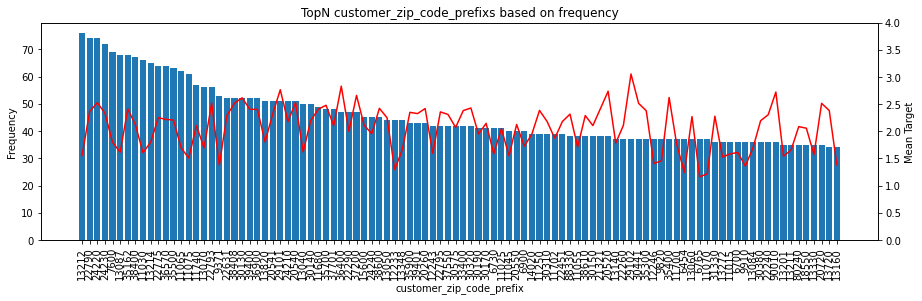

In [9]:
col= 'customer_zip_code_prefix'    
plot_topN(df, col, num=100)    

## Customer City 별 판매 개수 및 Classes 값의 평균 분포
특정 도시 몇 개에서 주문이 집중 됨을 알 수 있습니다.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


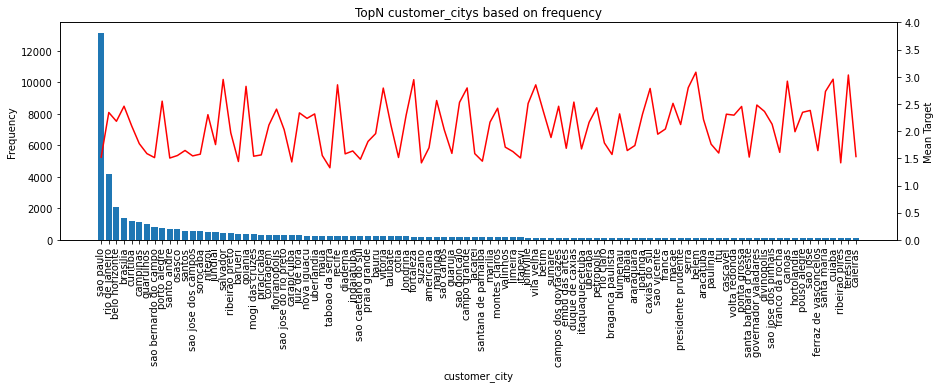

In [10]:
col= 'customer_city'    
plot_topN(df, col, num=100)    

## Customer State 별 판매 개수 및 Classes 값의 평균 분포
특정 주 몇개에서 판매가 집중됨을 알 수 있고, 특정 주는 평균 Taregt의 평균이 높은 것을 알 수 있습니다.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


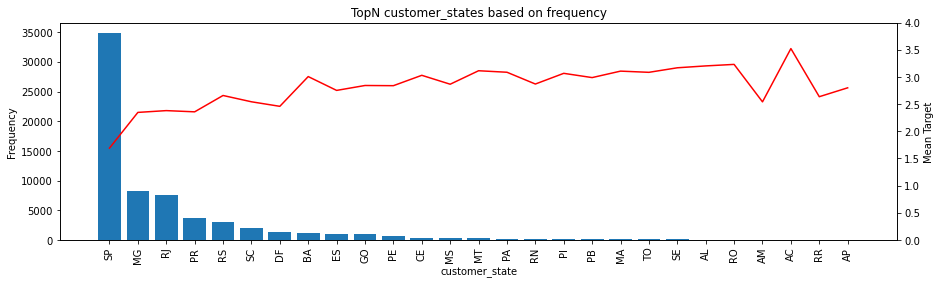

In [11]:
col= 'customer_state'    
plot_topN(df, col, num=100)    

## Seller Zip 별 판매 개수 및 Classes 값의 평균 분포

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


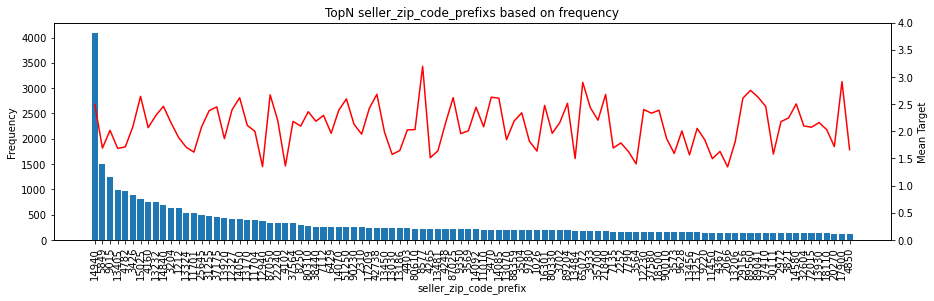

In [12]:
col= 'seller_zip_code_prefix'    
plot_topN(df, col, num=100)    

## Seller City 별 판매 개수 및 Classes 값의 평균 분포

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


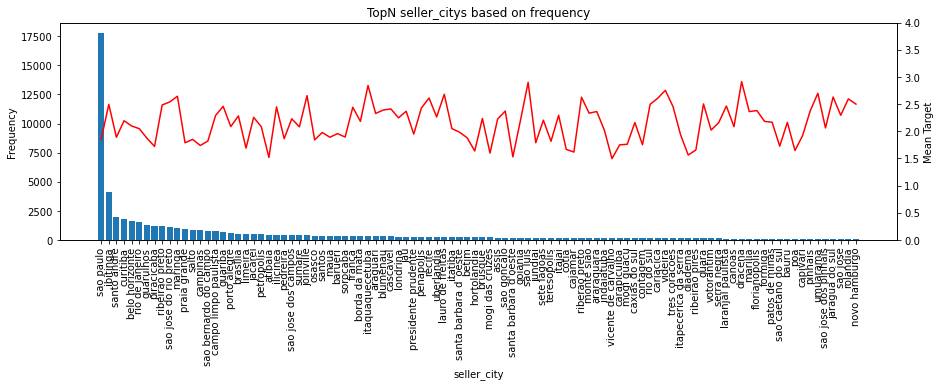

In [13]:
col= 'seller_city'    
plot_topN(df, col, num=100)    

## Seller State 별 판매 개수 및 Classes 값의 평균 분포

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator


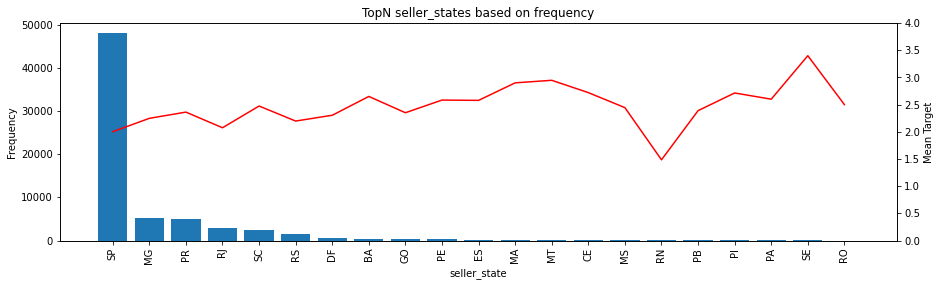

In [14]:
col= 'seller_state'    
plot_topN(df, col, num=100)    

## 일자 별 판매 개수 분포
일자별 Target 평균의 분포 입니다. 일자 별로 Up and Down이 보입니다. 일자에 영향을 받는 다는 것을 알 수 있습니다.

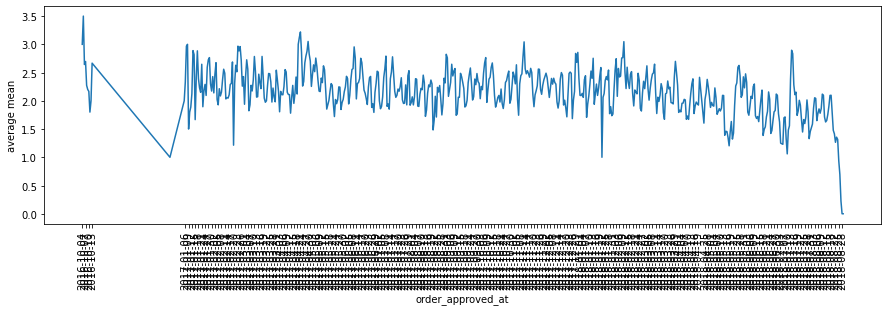

In [15]:
def show_classes_date(df, frac=1.0):
    df = df.sample(frac=frac, random_state= 100)
    plt.figure(figsize=(15,4))
    plt.plot(df[['date', 'classes']].groupby('date').classes.mean())
    plt.ylabel('average mean')
    plt.xlabel('order_approved_at')
    plt.xticks(df[['date', 'classes']].groupby('date').classes.mean().index[::3], rotation='vertical')
    print('')
    
df['date'] = pd.to_datetime(df['order_approved_at']).dt.date    
show_classes_date(df, frac=1.0)    

## 숫자(Numeric) 컬럼 값의 분포
각 숫자 컬럼값의 분포를 확인 합니다.

,classes,customer_zip_code_prefix,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix
count,67176.000000,67176.000000,67176.000000,67176.000000,67176.000000,67176.000000,67176.000000,67176.000000,67176.000000
mean,2.088276,30136.152525,119.612015,18.237162,1925.296494,29.510249,16.028761,22.781660,24156.154847
std,1.152390,28851.374098,181.889134,13.688755,3458.277432,15.600226,12.777290,11.447973,27561.745270
min,0.000000,1003.000000,0.850000,0.000000,0.000000,7.000000,2.000000,6.000000,1001.000000
25%,1.000000,8256.500000,39.900000,12.140000,275.000000,18.000000,8.000000,15.000000,5849.000000
50%,2.000000,18207.000000,74.000000,15.300000,650.000000,24.000000,13.000000,20.000000,13419.000000
75%,3.000000,38304.000000,130.000000,19.250000,1700.000000,36.000000,20.000000,30.000000,27277.000000
max,4.000000,99980.000000,6499.000000,409.680000,30000.000000,105.000000,105.000000,118.000000,99730.000000


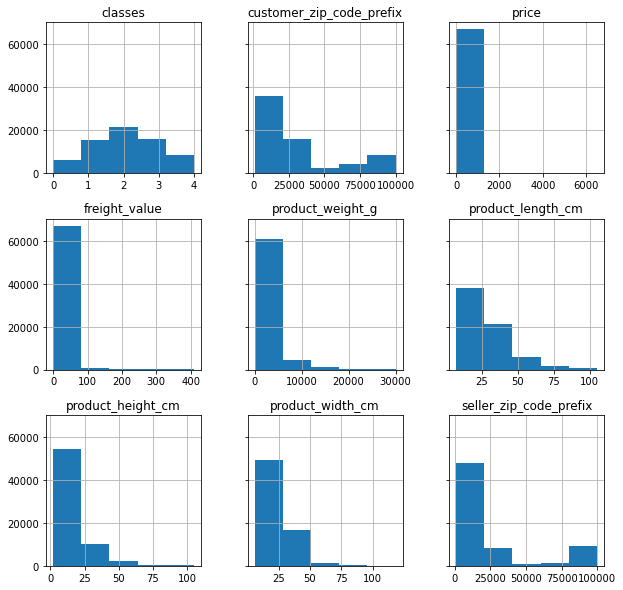

In [16]:
# Histograms for each numeric features
display(df.describe())
%matplotlib inline
hist = df.hist(bins=5, sharey=True, figsize=(10, 10))

## 숫자(Numeric) 컬럼 항목의 레이블 영향 확인
여기서 눈여겨 봐야 할 부분은 Freight Value 입니다. 레이블이 0 인 것이 Freight Value의 X축의 값이 작습니다. 이것은 화물이 가벼울 수록 빨리 배달이 된다는 것을 의미 합니다.

classes
customer_zip_code_prefix


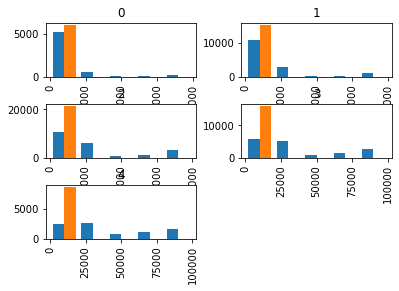

price


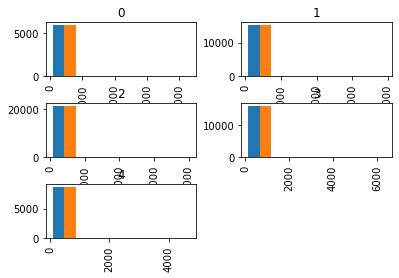

freight_value


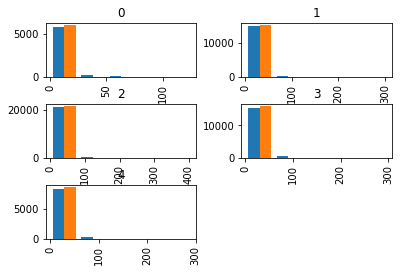

product_weight_g


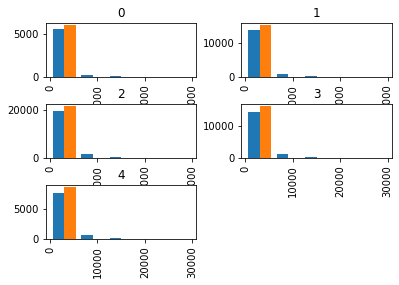

product_length_cm


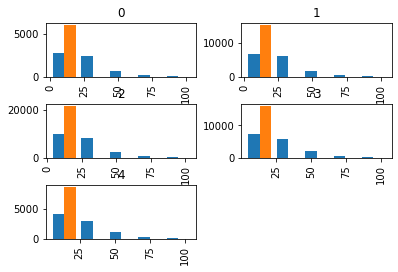

product_height_cm


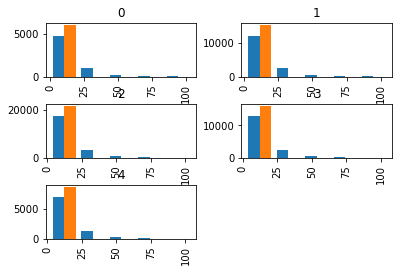

product_width_cm


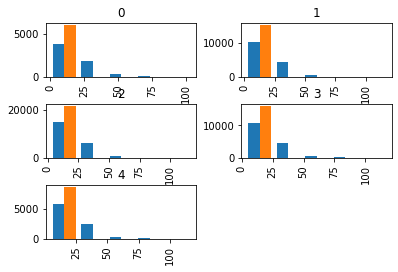

seller_zip_code_prefix


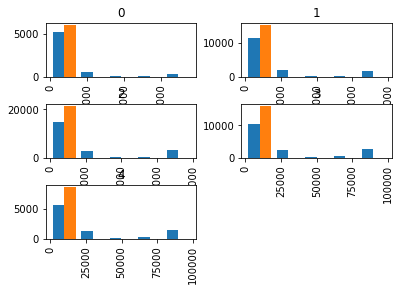

In [17]:
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    if column != 'classes':    
        hist = df[[column, 'classes']].hist(by='classes', bins=5)
        plt.show()

## Correlation Matrix
상관 매트릭스를 보면 classes와 가장 유사하게 상관이 있는 것은 freight_value인 것을 확인할 수 있습니다.

<AxesSubplot:>

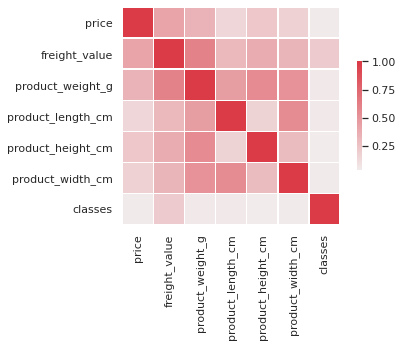

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
cmap = sns.diverging_palette(20,10, as_cmap=True)
cols = ['price','freight_value','product_weight_g','product_length_cm','product_height_cm','product_width_cm','classes']
sns.heatmap(df[cols].corr(), vmax=1, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})